Elastic Modulus and Poissons Ratio Fitting & Viewer

In [ ]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt; import numpy as np
from pvc_tensile_experiment.Functions import *

def LinearFit(x, a, b):
    return a*x + b

# create a dataframe to save the data 
df = pd.DataFrame(columns = ["Plasticizer", "Elastic Modulus (Pa)", "Poissons Ratio", "Bulk Modulus"])
i = 0

# plot parameters
markerSize = 0.5
titleSize = 15
axisSize = 11
legendSize = 11

# the desired plasticizer ratio 
for plastiRatio in ['P2', 'P4', 'P6', 'P8']:

    # compile all the data  
    _, axStrain, _, transStrain, stress = InstronDataCompile('Elastic Data', plastiRatio)

    # define the elastic region
    elasRegion = np.where(axStrain < 0.3) 

    # curve fit the elastic region. 
    xfit = np.linspace(axStrain[elasRegion][0], axStrain[elasRegion][-1])
    poptE, pcovE = curve_fit(LinearFit, axStrain[elasRegion], stress[elasRegion]*1e6)
    poptP, pcovP = curve_fit(LinearFit, axStrain[elasRegion], transStrain[elasRegion])

    # plot engineering stress vs strain
    plt.figure(0)
    plt.scatter(axStrain[elasRegion], stress[elasRegion]*1e6, s = markerSize, label = f'{plastiRatio} Gel')
    # plt.plot(xfit, LinearFit(xfit, poptE[0], poptE[1]), 'black')
    plt.xlabel('Axial Strain', fontsize = axisSize)
    plt.ylabel('Stress (Pa)', fontsize = axisSize)
    plt.title(f'PVC Gel Elastic Modulus (Pa)', fontsize = titleSize)
    plt.legend(fontsize = legendSize)

    # plot poissons ratio
    plt.figure(1)
    plt.scatter(axStrain[elasRegion], transStrain[elasRegion], s = markerSize, label = f'{plastiRatio} Gel')
    # plt.plot(xfit, LinearFit(xfit, poptP[0], poptP[1]), 'black', )
    plt.xlabel('Axial Strain', fontsize = axisSize)
    plt.ylabel('Transverse Strain', fontsize = axisSize)
    plt.title(f'PVC Gel Poissons Ratio', fontsize = titleSize)
    plt.legend(fontsize = legendSize)

    df.loc[i] = [plastiRatio, poptE[0], poptP[0], poptE[0]/2/(1 - 2*poptP[0])]
    i = i + 1
plt.show()

df.to_csv(f"Data/PVC Gel Material Parameters.csv", sep = ',', header = True, index = False)

Elastic Modulus Data Excel Combiner & Exporter

In [ ]:
from pvc_tensile_experiment.Functions import *; import numpy as np


# the desired plasticizer ratio 
for plastiRatio in ['P2', 'P4', 'P6', 'P8']:

    # compile all the data  
    _, axStrain, _, transStrain, stress = InstronDataCompile('Elastic Data', plastiRatio)

    # find the elastic region
    elasRegion = np.where(axStrain < 0.3) 

    # save the nominal stress and stretch data 
    df = pd.DataFrame(columns = ["Transverse Strain", "Eng. Axial Strain", "Eng. Stress (Pa)"])
    df["Transverse Strain"] = transStrain[elasRegion]
    df["Eng. Axial Strain"] = axStrain[elasRegion]
    df["Eng. Stress (Pa)"] = stress[elasRegion]    
    
    # df.to_csv(f"Data/{plastiRatio} Uniaxial Tensile Data.csv", sep = ',', header = True, index = False)


Hyperelastic Data and Incompressibilty Assumption Viewer

In [ ]:
from pvc_tensile_experiment.Functions import InstronDataCompile
import matplotlib.pyplot as plt; import numpy as np

# Compute R-squared
def RSquared(yTrue, yPredict):
    ssResidual = np.sum((yTrue - yPredict) ** 2)
    ssTotal = np.sum((yTrue - np.mean(yTrue)) ** 2)
    return 1 - (ssResidual / ssTotal)

# preallocate the suplots
fig, axs1 = plt.subplots(1,1, layout = "constrained")
fig, axs2 = plt.subplots(1,1, layout = "constrained")
fig, axs3 = plt.subplots(1,1, layout = "constrained")

# plot parameters
markerSize = 0.5
titleSize = 15
axisSize = 11
legendSize = 11

# plot the ideal incompressability condition
stretch = np.arange(1.0, 4.5, 0.01)
axs1.plot(stretch, np.sqrt(1/stretch), label = 'Theoretical Fit', c = 'k')
axs1.legend(fontsize = 11)

# the desired plasticizer ratio 
for plastiRatio in ['P2', 'P4', 'P6', 'P8']:

    # read the processed data files 
    _, axStrain, _, transStrain, stress = InstronDataCompile(f'Hyperelastic Data/', plastiRatio)

    # find true strain and stress from engineering strain
    stretch = 1 + axStrain
    transverseStretch = 1 + transStrain
    stress = stress*1e6
    stressTrue = stress*stretch

    # print the coeff of determination per dataset
    coeffDet = RSquared( np.sqrt(1/stretch[np.isnan(stretch) == False]), -transverseStretch[np.isnan(stretch) == False] + 2)

    # plot inverse stretch ratio showing isotropic and incompressable
    axs1.scatter(stretch, -transverseStretch + 2, label = f'{plastiRatio}, $R^2$ = {np.round(coeffDet, 2)}', s = markerSize)
    axs1.set_xlabel('Axial Stretch', fontsize = axisSize)
    axs1.set_ylabel('Transverse Stretch', fontsize = axisSize)
    axs1.set_title("Incompressability Assumption", fontsize = titleSize)
    axs1.legend(fontsize = legendSize)

    # plot engineering stress-strain 
    axs2.scatter(axStrain*1e2, stress, s = markerSize, label = f'{plastiRatio}')   
    axs2.set_xlabel('Engineering Strain (%)', fontsize = axisSize)
    axs2.set_ylabel('Engineering Stress (Pa)', fontsize = axisSize)
    axs2.set_title('PVC Gel Engineering Stress', fontsize = titleSize)
    axs2.legend(fontsize = legendSize)
    
    # plot true stress-strain
    axs3.scatter(stretch, stressTrue, s = markerSize, label = f'{plastiRatio}')
    axs3.set_xlabel('Stretch', fontsize = axisSize)
    axs3.set_ylabel('True Stress (Pa)', fontsize = axisSize)
    axs3.set_title('PVC Gel True Stress', fontsize = titleSize)
    axs3.legend(fontsize = legendSize)
plt.show()

Hyperealastic Fitting

In [ ]:
"""Nominal Engineering-Stretch Hyperelastic Model Fitting"""
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
from pvc_tensile_experiment.Functions import *


# define the plasticizer ration we want
plastiRatio = 'P2'

# compile all the data  
_, axStrain, _, _, stress = InstronDataCompile('Hyperelastic Data', plastiRatio)

# convert from engineering measurements to true measurements
stretch = 1 + axStrain
stress = stress*1e6

# Define hyperelastic models
def NeoHookean(params, stretch):
    mu = params[0]
    return mu*(stretch - 1/stretch**2)

def MooneyRivlin(params, stretch):
    C10, C01 = params
    return 2*(stretch - 1/stretch**2)*(C10 + C01/stretch)

def Yeoh(params, stretch):
    C10, C20, C30 = params
    I1 = stretch**2 + 2/stretch
    return 2*(stretch - 1/stretch**2)*(C10 + 2*C20*(I1 - 3) + 3*C30*(I1 - 3)**2)

def InvLangevin(x):
    if np.abs(x) < 0.84136:
        return 1.31446*np.tan(1.58986*x) + 0.91209*x
    elif np.abs(x) >= 0.84136:
        return 1/(np.abs(x)/x*-x)

def EightChain(params, stretch):
    mu, stretchLock = params
    chainStretch = np.sqrt((stretch**2 + 2/stretch)/3)    
    return mu/chainStretch*(stretch**2 - 1/stretch)*InvLangevin(chainStretch/stretchLock)/InvLangevin(1/stretchLock)

def Ogden(params, stretch):
    mu, alpha, mu1, alpha1, mu2, alpha2 = params
    return 2*mu/alpha*(stretch**(alpha - 1) - stretch**(-alpha/2 - 1)) + 2*mu1/alpha1*(stretch**(alpha1 - 1) - stretch**(-alpha1/2 - 1)) + 2*mu2/alpha2*(stretch**(alpha2 - 1) - stretch**(-alpha2/2 - 1))

def Gent(params, stretch):
    mu, Jm = params
    return mu*(stretch - 1/stretch**2)*(Jm/(Jm - (stretch**2 + 2/stretch - 3)))

def ExtendedTube(params, stretch):
    Gc, Ge, beta, delta = params
    I1 = stretch**2 + 2/stretch
    return Gc*(stretch - 1/stretch**2)*((1 + (1 + I1**2 - 4*I1)*delta**2 + (5*I1 - I1**2 - 6)*delta**4)/(1 - (I1 - 3)*delta**2)**2) - 2*Ge/beta*(stretch**(-beta) - stretch**(beta/2))


# Define fitting function
def FitModel(model, stretch, stress, paramGuess):
    def residuals(params):
        return model(params, stretch) - stress
    optParams, _ = opt.least_squares(residuals, paramGuess, method = 'lm', max_nfev = 1000).x, None
    return optParams

# Compute R-squared
def RSquared(yTrue, yPredict):
    ssResidual = np.sum((yTrue - yPredict) ** 2)
    ssTotal = np.sum((yTrue - np.mean(yTrue)) ** 2)
    return 1 - (ssResidual / ssTotal)


# Models and initial guesses
models = {
    "Neo-Hookean": (NeoHookean, [1.0e6]),
    "Mooney-Rivlin": (MooneyRivlin, [1.0e6, 0.1e6]),
    "Yeoh": (Yeoh, [1.0e6, -0.1e4, 0.01e2]),
    "Gent": (Gent, [1.0e1, 100e6]),
    # "Arruda-Boyce": (EightChain, [1.0, 10]),
    "Ogden": (Ogden, [10.0e4, 1.0, -7.0e4, 2.0,  5.0e4, 2.0]),
    "ExtendedTube": (ExtendedTube, [1.0e6, 1.0e6, 0.7, 0.1])
}

# Fit models
fitResults = {}
for name, (model, guess) in models.items():
    params = FitModel(model, stretch, stress, guess)
    predictedStress = model(params, stretch)
    r2 = RSquared(stress, predictedStress)
    fitResults[name] = (params, r2)

# Print results
for name, (params, r2) in fitResults.items():
    print(f"{name} Model: Parameters = {params}, R^2 = {r2:.4f}")

# Plot results
plt.figure(figsize = (8, 6))
plt.scatter(stretch, stress, s = 2, label = "Data", color = "black")

for name, (params, _) in fitResults.items():
    plt.plot(stretch, models[name][0](params, stretch), label = name, linewidth = 2, linestyle = 'dotted')

plt.xlabel("Stretch Ratio")
plt.ylabel("Nominal Stress (MPa)")
plt.legend()
plt.title("Hyperelastic Model Fits")
plt.show()


In [ ]:
"""True Stress- Strain Hyperelastic Model Fitting"""
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
from pvc_tensile_experiment.Functions import *


# define the plasticizer ration we want
plastiRatio = 'P4'

# compile all the data  
axDist, axStrain, transDist, transStrain, stress = TensileDataCompile(plastiRatio)

# convert to true stress-strain
stretch = 1 + axStrain
trueStress = stress*stretch*1e6


# define hyperelastic models
def NeoHookean(params, stretch):
    mu = params[0]
    return mu*(stretch**2 - 1/stretch)

def MooneyRivlin(params, stretch):
    C10, C01 = params
    return 2*(stretch**2 - 1/stretch)*(C10 + C01/stretch)

def Yeoh(params, stretch):
    C10, C20, C30 = params
    I1 = stretch**2 + 2/stretch
    return 2*(stretch**2 - 1/stretch)*(C10 + 2*C20*(I1 - 3) + 3*C30*(I1 - 3)**2)

def InvLangevin(x):
    if np.abs(x) < 0.84136:
        return 1.31446*np.tan(1.58986*x) + 0.91209*x
    elif np.abs(x) >= 0.84136:
        return 1/(np.abs(x)/x*-x)

def EightChain(params, stretch):
    mu, stretchLock = params
    chainStretch = np.sqrt((stretch**2 + 2/stretch)/3)    
    return mu/chainStretch*(stretch**2 - 1/stretch)*InvLangevin(chainStretch/stretchLock)/InvLangevin(1/stretchLock)

def Ogden(params, stretch):
    mu, alpha, mu1, alpha1, mu2, alpha2 = params
    return 2*mu/alpha*(stretch**(alpha) - stretch**(-alpha/2)) + 2*mu1/alpha1*(stretch**(alpha1) - stretch**(-alpha1/2)) + 2*mu2/alpha2*(stretch**(alpha2) - stretch**(-alpha2/2))

def Gent(params, stretch):
    mu, Jm = params
    return mu*(stretch**2 - 1/stretch)*(Jm/(Jm - (stretch**2 + 2/stretch - 3)))

def ExtendedTube(params, stretch):
    Gc, Ge, beta, delta = params
    I1 = stretch**2 + 2/stretch
    return Gc*(stretch**2 - 1/stretch)*((1 + (1 + I1**2 - 4*I1)*delta**2 + (5*I1 - I1**2 - 6)*delta**4)/(1 - (I1 - 3)*delta**2)**2) - 2*Ge/beta*(stretch**(-beta) - stretch**(beta/2))


# define fitting function
def FitModel(model, stretch, trueStress, paramGuess):
    def residuals(params):
        return model(params, stretch) - trueStress
    optParams, _ = opt.least_squares(residuals, paramGuess, method = 'lm', max_nfev = 1000).x, None
    return optParams

# compute R-squared
def RSquared(yTrue, yPredict):
    ssResidual = np.sum((yTrue - yPredict) ** 2)
    ssTotal = np.sum((yTrue - np.mean(yTrue)) ** 2)
    return 1 - (ssResidual / ssTotal)


# models and initial guesses
models = {
    # "Neo-Hookean": (NeoHookean, [1.0]),
    # "Mooney-Rivlin": (MooneyRivlin, [1.0, 0.1]),
    "Yeoh": (Yeoh, [10.0e6, 10e4, 0.01e2]),
    # "Gent": (Gent, [1000, 100]),
    # "Arruda-Boyce": (EightChain, [1.0, 10]),
    "Ogden": (Ogden, [-0.27500592e6,  1.53251067,  0.49723726e6,  2.43781332, -0.22544583e6,  2.7956833 ]),
    "ExtendedTube": (ExtendedTube, [10.0e6, 5e6, 0.6, 0.02])
}

# Fit models
fitResults = {}
for name, (model, guess) in models.items():
    params = FitModel(model, stretch, trueStress, guess)
    predictedStress = model(params, stretch)
    r2 = RSquared(trueStress, predictedStress)
    fitResults[name] = (params, r2)

# Print results
for name, (params, r2) in fitResults.items():
    print(f"{name} Model: Parameters = {params}, R^2 = {r2:.4f}")

# Plot results
plt.figure(figsize = (8, 6))
plt.scatter(stretch, trueStress, s = 2, label = "Data", color = "black")

for name, (params, _) in fitResults.items():
    plt.plot(stretch, models[name][0](params, stretch), label = name)

plt.xlabel("True Strain")
plt.ylabel("True Stress")
plt.legend()
plt.title("Hyperelastic Model Fits")
plt.show()

Viscoelastic Processing

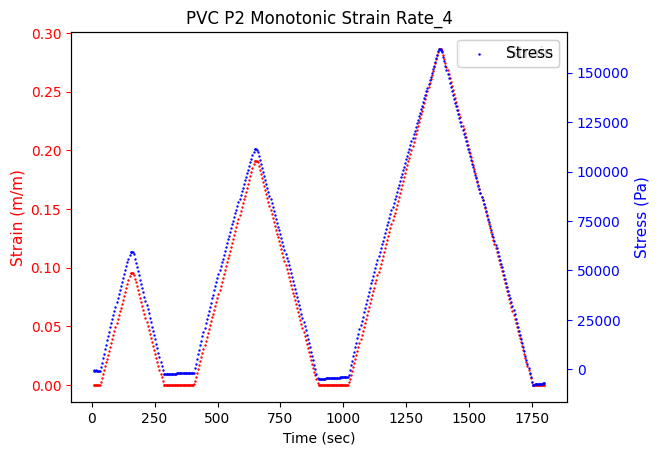

C:\Users\facci\AppData\Local\Temp\ipykernel_20052\2324349279.py:77: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


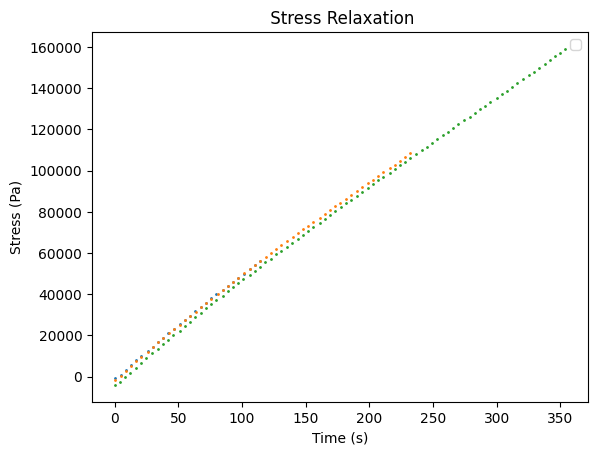

In [72]:
import numpy as np
import matplotlib.pyplot as plt
# from pvc_tensile_experiment.Functions import *

# this function converts the raw excel file from the DMA to base units and converts into engineering stress-strain
def ViscoelasticDataProcessor(folderName, name):
    # import the excel file. dont use columns beyond 4 since they're empty  due to 
    # needing a place to put extra comments
    df = pd.read_excel(f"Data/Viscoelastic Data/{folderName}/{name}", header = None, usecols = [0, 1, 2, 3, 4])
    name = name.removesuffix('.xlsx')

    # get sample geometric data. length is in mm and area is in mm^2
    sampleLength = df.loc[5][1]*1e-3
    sampleArea = df.loc[6][1]*1e-6

    # preallocate the measurement names
    data = df.loc[df.index[28::]].to_numpy(dtype = float)
    
    
    # dataColumns = ['Time (s)', 'Temp. (Cel)', 'Displacement (m)', 'Load (N)', 'Displacement Rate (m/s)']
    data[:, 0] = data[:, 0]*60      # time -  converted from min to sec
    data[:, 2] = data[:, 2]*1e-6    # displacement - converted from um to m
    data[:, 3] = data[:, 3]*1e-6    # force - converted from N to uN
    data[:, 4] = data[:, 4]*1e-6*60 # displacement rate - converted from um/min to m/s

    # transpose the data then save strain, strain rate, and stress
    data = data.T
    data = np.vstack([data, data[2, :]/sampleLength, data[4, :]/sampleLength, data[3, :]/sampleArea])
    data = data.T
    return data, name

plastiRatio = 'P2'
folder = 'Monotonic Strain Rate'

fileNames = [i for i in os.listdir(f'Data/Viscoelastic Data/{folder}') if i.endswith('.xlsx')]

for i in fileNames:
    data, name  = ViscoelasticDataProcessor(folder, i)

time = data[:, 0]
strain = data[:, 5]
stress = data[:, 7]

regions = StrainRateRegionSelector(strain)

# plot parameters
markerSize = 0.5
titleSize = 15
axisSize = 11
legendSize = 11

# preallocate the plots and the second y axis
fig, ax = plt.subplots()
ax1 = ax.twinx()

# set the plotting functions
ax.scatter(time, strain, s = markerSize, c = 'r', label = 'Strain')
ax.set_ylabel('Strain (m/m)', color = 'r', fontsize = axisSize)
ax.tick_params('y', colors = 'r')
ax.set_xlabel('Time (sec)')
ax.legend(fontsize = legendSize)

ax1.scatter(time, stress, s = markerSize, c = 'b',  label = 'Stress')
ax1.set_ylabel('Stress (Pa)',  color = 'b', fontsize = axisSize)
ax1.tick_params('y', colors = 'b')
ax1.legend(fontsize = legendSize)
plt.title(f'{name}')
plt.show()

for i in range(0,3):
    indexRange = regions[regions[:,i] > 0, i]
    strainRate = np.round(np.average(data[indexRange, 6]), 4)
    plt.scatter(time[indexRange] - time[indexRange][0], stress[indexRange], s = 1)
    plt.ylabel('Stress (Pa)')
    plt.xlabel('Time (s)')
    plt.title(f' Stress Relaxation')
    plt.legend()
plt.show()

Viscoelastic Monotonic Strain Rate Fitting

SLS Model: Parameters = [5.14166111e+05 1.88328426e+05 3.10701559e-02], R^2 = 1.0000
Prony2Term Model: Parameters = [4.15951676e+05 1.88048848e+05 3.10394621e-02 9.84954972e+04
 2.77075934e+01], R^2 = 1.0000
SLS Model: Parameters = [4.71331340e+05 2.20151152e+05 4.95078244e-02], R^2 = 1.0000
Prony2Term Model: Parameters = [3.78887341e+05 2.20025577e+05 4.94889203e-02 9.25701463e+04
 9.35159592e+01], R^2 = 1.0000
SLS Model: Parameters = [5.32056748e+05 1.82425003e+05 2.61585498e-02], R^2 = 1.0000
Prony2Term Model: Parameters = [5.31057738e+05 1.82424127e+05 2.61583802e-02 1.00000006e+03
 1.00000000e+02], R^2 = 1.0000


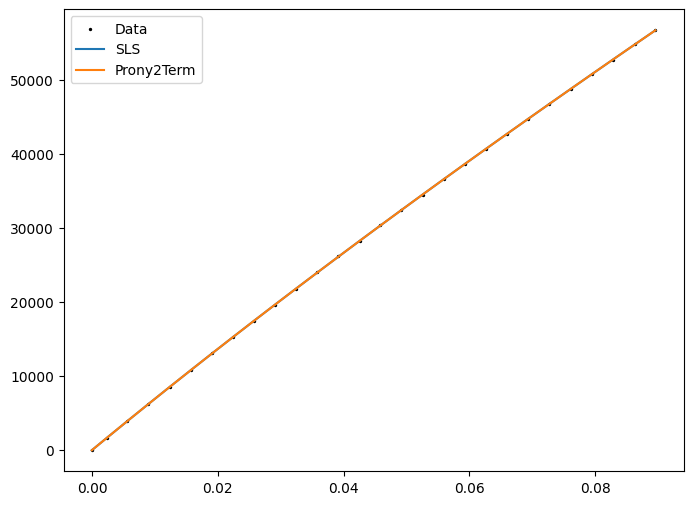

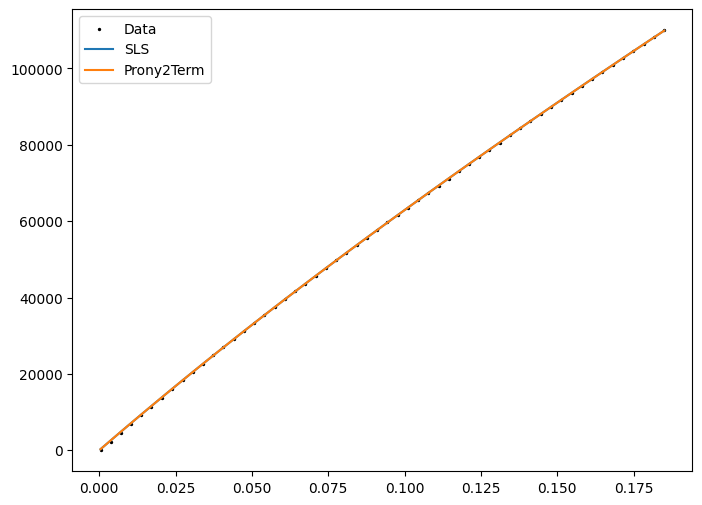

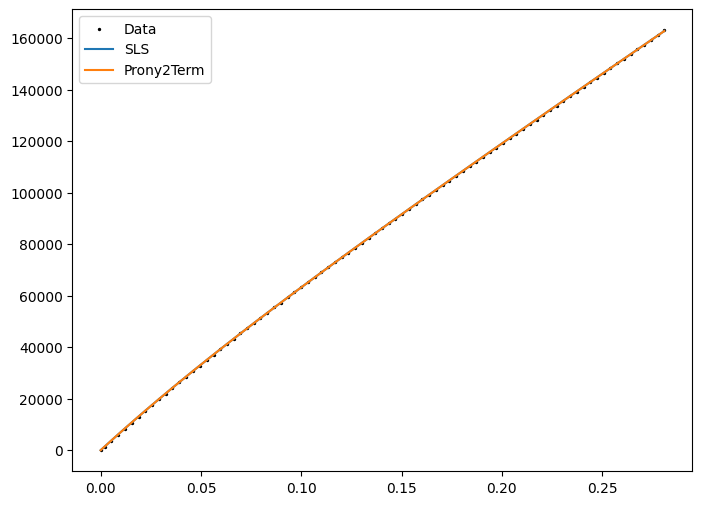

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt


# define the Prony series and SLS model
def SLS(params, strain):
    EInf, E1, tau = params
    return EInf*strain + E1*tau*strainRate*(1 - np.exp(-strain/(tau*strainRate))) 

def Prony2Term(params, strain):
    EInf, E1, tau1, E2, tau2 = params

    return (EInf*strain +
            E1*tau1*strainRate*(1 - np.exp(-strain/(tau1*strainRate))) +
            E2*tau2*strainRate*(1 - np.exp(-strain/(tau2*strainRate))))

def Prony3Term(params, strain):
    EInf, E1, tau1, E2, tau2, E3, tau3 = params
    return (EInf*strain +
            E1*tau1*strainRate*(1 - np.exp(-strain/(tau1*strainRate))) +
            E2*tau2*strainRate*(1 - np.exp(-strain/(tau2*strainRate))) +
            E3*tau3*strainRate*(1 - np.exp(-strain/(tau3*strainRate))))


# define fitting function
def FitModel(model, strain, stress, paramGuess, boundaries):
    def residuals(params):
        return model(params, strain) - stress
    optParams, _ = opt.least_squares(residuals, paramGuess, bounds = boundaries, method = 'trf', max_nfev = 1000).x, None
    return optParams

# compute R-squared 
def RSquared(yTrue, yPredict):
    ssResidual = np.sum((yTrue - yPredict) ** 2)
    ssTotal = np.sum((yTrue - np.mean(yTrue)) ** 2)
    return 1 - (ssResidual / ssTotal)


# models and initial guesses
models = {
    "SLS": (SLS, [4e5, 12e4, 0.5], ([1e5, 1e5, 0.01], [1e6, 1e6, 1])),
    "Prony2Term": (Prony2Term, [296732, 100e3, 1, 100e3, 50],([1e5, 1e2 , 0.01, 1e3, 10], [3e6, 1e6, 1, 1e5, 100])),
    # "Prony3Term": (Prony3Term, [296732, 500e3, 0.1, 10e3, 5, 5e3, 50])
    }

for i in range(0,3):
    indexRange = regions[regions[:,i] > 0, i]
    strainfit = strain[indexRange]
    stressfit = stress[indexRange] - stress[indexRange[0]]

    # Fit models
    fitResults = {}
    for name, (model, guess, boundaries) in models.items():
        params = FitModel(model, strainfit, stressfit, guess, boundaries)
        predictedStress = model(params, strainfit)
        r2 = RSquared(stressfit, predictedStress)
        fitResults[name] = (params, r2)
        
    # Print results
    for name, (params, r2) in fitResults.items():
        print(f"{name} Model: Parameters = {params}, R^2 = {r2:.4f}")

    # Plot results
    plt.figure(figsize = (8, 6))
    plt.scatter(strainfit, stressfit, s = 2, label = "Data", color = "black")

    for name, (params, _) in fitResults.items():
        plt.plot(strainfit, models[name][0](params, strainfit), label = name)
        plt.legend()

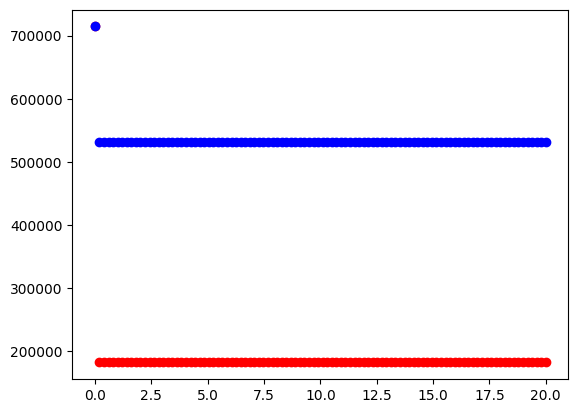

In [75]:
def SLS(params, t):
    EInf, E1, tau = params
    return E1 + EInf*np.exp(-t/tau)

def Prony2Term(params, t):
    EInf, E1, tau1, E2, tau2 = params
    return EInf + E1*np.exp(-t/tau1) + E2*np.exp(-t/tau2)


for i in np.linspace(0, 20, 100):
    plt.scatter(i, SLS(fitResults['SLS'][0], i), c = 'r', label = 'SLS')
    plt.scatter(i, Prony2Term(fitResults['Prony2Term'][0], i), c = 'b', label = 'Prony 2 Term')

Viscoelastic Stress Relaxation Curve Fitting

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

# define the Prony series and SLS model
def SLS(params, t):
    EInf, E1, tau = params
    return E1 + EInf*np.exp(-t/tau)

def Prony2Term(params, t):
    EInf, E1, tau1, E2, tau2 = params
    return EInf + E1*np.exp(-t/tau1) + E2*np.exp(-t/tau2)

def Prony3Term(params, t):
    EInf, E1, tau1, E2, tau2, E3, tau3 = params
    return EInf + E1*np.exp(-t/tau1) + E2*np.exp(-t/tau2) + E3*np.exp(-t/tau3)


# define fitting function
def FitModel(model, t, stress, paramGuess):
    def residuals(params):
        return model(params, t) - stress
    optParams, _ = opt.least_squares(residuals, paramGuess, method = 'lm', max_nfev = 1000).x, None
    return optParams

# compute R-squared 
def RSquared(yTrue, yPredict):
    ssResidual = np.sum((yTrue - yPredict) ** 2)
    ssTotal = np.sum((yTrue - np.mean(yTrue)) ** 2)
    return 1 - (ssResidual / ssTotal)


# models and initial guesses
models = {
    "SLS": (SLS, [40e5, 200e3, 100]),
    "Prony2Term": (Prony2Term, [296732, 100e3, 1, 100e3, 50]),
    # "Prony3Term": (Prony3Term, [296732, 500e3, 0.1, 10e3, 5, 5e3, 50]),
    }

# Fit models
fitResults = {}
for name, (model, guess) in models.items():
    params = FitModel(model, Time, Stress, guess)
    predictedStress = model(params, Time)
    r2 = RSquared(Stress, predictedStress)
    fitResults[name] = (params, r2)
    
# Print results
for name, (params, r2) in fitResults.items():
    print(f"{name} Model: Parameters = {params}, R^2 = {r2:.4f}")

# Plot results
plt.figure(figsize = (8, 6))
plt.scatter(Time, Stress, s = 2, label = "Data", color = "black")

for name, (params, _) in fitResults.items():
    plt.plot(Time, models[name][0](params, Time), label = name)
    plt.legend()